## Rainfall spatial distribution

In [25]:
import warnings
warnings.filterwarnings("ignore")
import dask_jobqueue
import pyart
import dask
import numpy as np
import dask.bag as db
import xarray
import pandas
import cartopy.crs as ccrs

from datetime import datetime
from scipy import ndimage
from glob import glob
from netCDF4 import Dataset

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [26]:
exclude_fields = ['unfolded_differential_phase', 'specific_atteunation_reflectivity',
                  'specific_attenuation_differential_reflectivity',
                  'radar_echo_classification',
                  'D0', 'NW', 'velocity', 'cross_correlation_ratio', 
                  'differential_reflectivity', 'corrected_differential_reflectivity',
                  'differential_phase', 'corrected_differential_phase',
                  'spectrum_width', 'signal_to_noise_ratio', 'velocity_texture', 'ROI']
year_list = ['1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
             '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
dros_index = []

def area_anal(pixel_area, rr_x, rain_rates):
    A_rainrate = np.zeros(rr_x.shape)
    N_rainrate = np.zeros(rr_x.shape)
    Rm_rainrate = np.zeros(rr_x.shape)
    for i in range(len(rr_x)):
        b_fld = np.zeros(rain_rates.shape)
        b_fld[rain_rates > rr_x[i]] = 1.0
        regions, N_rainrate[i] = ndimage.label(b_fld)
        try:
            A_rainrate[i] = (len(np.where( regions > 0.5)[0]) * pixel_area)
            Rm_rainrate[i] = rain_rates[ np.where(regions > 0.5)].mean()
        except IndexError:
            A_rainrate[i] = 0.0
            Rm_rainrate[i] = 0.0
    return N_rainrate, A_rainrate, Rm_rainrate


def get_rainfall_spatial_variability(file):
    Grid = pyart.io.read_grid(file, exclude_fields=exclude_fields)
    print(Grid.time['data'])
    rain_rate = Grid.fields['radar_estimated_rain_rate']['data']
    rain_rate = np.ma.filled(rain_rate[3], np.nan)
    pixel_area = 1
    rr_x = np.arange(1.0, 150, 1.0)
    N_rainrate, A_rainrate, Rm_rainrate = area_anal(pixel_area, rr_x, rain_rate)
    del Grid
    return N_rainrate, A_rainrate, Rm_rainrate

In [ ]:
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=36, project='rainfall', walltime='1:15:00', 
                       job_cpu=36, memory='128GB', processes=18)

cluster.scale(36)         # Ask for ten workers

from dask.distributed import Client
client = Client(cluster)  # Connect this local process to remote workers

# wait for jobs to arrive, depending on the queue, this may take some time

import dask.array as da

In [ ]:
#Stop the cluster with this line after analysis is done!
cluster.stop_all_jobs()

In [ ]:
client

In [ ]:
# Load all of the data

mjo_index = []
N = []
A = []
Rm = []
for the_year in year_list:
    print('Loading year ' + the_year)
    rad_list = glob(('/lcrc/group/earthscience/radar/CPOL_level_1b/GRIDDED/GRID_70km_1000m/' + the_year + '/**/*.nc'), 
                    recursive=True)
    rad_list = sorted(rad_list)
    the_bag = db.from_sequence(rad_list)
    %time outs = the_bag.map(get_rainfall_spatial_variability).compute()
    N.append(np.stack([x[0] for x in outs]))
    A.append(np.stack([x[1] for x in outs]))
    Rm.append(np.stack([x[2] for x in outs]))
    time_list = np.array([parse_time(x) for x in rad_list])
    dros_index.append(np.array([get_dros_class(x) for x in time_list]))
    mjo_index.append(np.array([get_mjo_index(x) for x in time_list]))

dros_index = np.concatenate(dros_index)
mjo_index = np.concatenate(mjo_index)
N = np.concatenate(N, axis=0)
A = np.concatenate(A, axis=0)
Rm = np.concatenate(Rm, axis=0)

In [222]:
time_list = []

for the_year in year_list:
    print('Loading year ' + the_year)
    rad_list = glob(('/lcrc/group/earthscience/radar/CPOL_level_1b/GRIDDED/GRID_70km_1000m/' + the_year + '/**/*.nc'), 
                    recursive=True)
    rad_list = sorted(rad_list)
    time_list.append(np.array([parse_time(x) for x in rad_list]))

time_list = np.concatenate(time_list)
time_list = list(time_list)
#new_ds = xarray.Dataset({'dros_index': (['time'],dros_index),
#                         'mjo_index': (['time'],mjo_index),
#                         'N': (['time', 'x'], N),
#                         'a': (['time', 'x'], A),
#                         'Rm': (['time', 'x'], Rm)}, coords={'time': time_list, 
#                                        'x': np.arange(1.0, 150, 1.0)})
#new_ds.to_netcdf('rain_rate_hists3.nc')

Loading year 1998
Loading year 1999
Loading year 2000
Loading year 2001
Loading year 2002
Loading year 2003
Loading year 2004
Loading year 2005
Loading year 2006
Loading year 2007
Loading year 2009
Loading year 2010
Loading year 2011
Loading year 2012
Loading year 2013
Loading year 2014
Loading year 2015
Loading year 2016
Loading year 2017


In [ ]:
new_ds.to_netcdf('rain_rate_hists3.nc')

In [ ]:
new_ds = xarray.open_dataset('/lcrc/group/earthscience/rjackson/rain_rate_hists3.nc')

In [ ]:

N = new_ds.N.values
A = new_ds.a.values
Rm = new_ds.Rm.values
dros_index = new_ds.dros_index.values
mjo_index = new_ds.mjo_index.values
new_ds

In [ ]:
mjo_index.shape

In [14]:
file_path = '/home/rjackson/data/Drosdowsky.cdf'
in_netcdf = Dataset(file_path)
year = in_netcdf.variables['year'][:]
month = in_netcdf.variables['month'][:]
day = in_netcdf.variables['day'][:]
groups = in_netcdf.variables['groups'][:]
in_netcdf.close()

mjo_index_file = '/home/rjackson/data/rmm.74toRealtime.txt'
data = pandas.read_csv(mjo_index_file,
                       header=2,
                       delim_whitespace=True)
data_matrix = np.ma.array(data.values)
yearm = data_matrix[:, 0]
monthm = data_matrix[:, 1]
daym = data_matrix[:, 2]
index = data_matrix[:, 5]

def parse_time(file):
    return datetime.datetime.strptime(file[-28:-15], '%Y%m%d_%H%M')

def get_dros_class(inp_time):  
    the_index = []
    the_index = np.where(np.logical_and.reduce((
        year == inp_time.year, month == inp_time.month, day == inp_time.day)))[0]
    if(the_index):
        return groups[the_index[0]]
    else:
        return np.nan

    
def get_mjo_index(inp_time):
    the_index = []
    the_index = np.where(np.logical_and.reduce((
        yearm == inp_time.year, monthm == inp_time.month, daym == inp_time.day)))[0]
    if(the_index):
        return index[the_index[0]]
    else:
        return np.nan

In [ ]:
time_bag = db.from_sequence(time_list)
dros_index = np.array(time_bag.map(get_dros_class).compute())
mjo_index = np.array(time_bag.map(get_mjo_index).compute())

In [ ]:
num_mjoinactive = len(np.where(np.logical_or(mjo_index < 4, mjo_index == 8))[0])
num_mjoactive = len(np.where(np.logical_and(mjo_index > 3, mjo_index < 8))[0])
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.plot(np.arange(1.0, 150, 1.0), N[np.logical_or(mjo_index < 4, mjo_index == 8)].sum(axis=0)/num_mjoinactive,
        label='MJO inactive')
ax.plot(np.arange(1.0, 150, 1.0), N[np.logical_and(mjo_index > 3, mjo_index < 8)].sum(axis=0)/num_mjoactive, 
        label='MJO active')
ax.set_xlabel('Rainfall rate [mm/hr]')
ax.set_ylabel('Number of regions/number of scans')
ax.set_yscale('log')
ax.legend()
plt.savefig('Number of regions vs MJO.pdf')

In [ ]:
num_mjoinactive = len(np.where(np.logical_or(mjo_index < 4, mjo_index == 8))[0])
num_mjoactive = len(np.where(np.logical_and(mjo_index > 3, mjo_index < 8))[0])
print(mjo_index[mjo_index == 4])
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(np.arange(1.0, 150, 1.0), A[np.logical_or(mjo_index < 4, mjo_index == 8)].sum(axis=0)/num_mjoinactive,
        label='MJO inactive')
ax.plot(np.arange(1.0, 150, 1.0), A[np.logical_and(mjo_index > 3, mjo_index < 8)].sum(axis=0)/num_mjoactive, 
        label='MJO active')
ax.set_xlabel('Rainfall rate [mm/hr]')
ax.set_ylabel('Area of rainfall rate [$km^2$]/number of scans')
ax.set_yscale('log')
ax.legend()
plt.savefig('Area of regions vs MJO.pdf')

In [ ]:
num_mjoinactive = len(np.where(dros_index == 0)[0])
num_mjoactive = len(np.where(dros_index == 1)[0])
print(mjo_index[mjo_index == 4])
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(np.arange(1.0, 150, 1.0), N[dros_index == 0].sum(axis=0)/num_mjoinactive,
        label='Break')
ax.plot(np.arange(1.0, 150, 1.0), N[dros_index == 1].sum(axis=0)/num_mjoactive, 
        label='Monsoon')
ax.set_xlabel('Rainfall rate [mm/hr]')
ax.set_ylabel('Number of regions/number of scans')
ax.legend()
ax.set_yscale('log')
plt.savefig('Number of regions vs monsoon.pdf')

In [ ]:
num_mjoinactive = len(np.where(dros_index == 0)[0])
num_mjoactive = len(np.where(dros_index == 1)[0])
print(mjo_index[mjo_index == 4], )
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(np.arange(1.0, 150, 1.0), A[dros_index == 0].sum(axis=0)/num_mjoinactive,
        label='Break')
ax.plot(np.arange(1.0, 150, 1.0), A[dros_index == 1].sum(axis=0)/num_mjoactive, 
        label='Monsoon')
ax.set_xlabel('Rainfall rate [mm/hr]')
ax.set_ylabel('Area of regions [$km^2$]/number of scans')
ax.legend()
ax.set_yscale('log')
plt.savefig('Area of regions vs monsoon.pdf')

In [10]:
hours = np.array([x.hour for x in time_list])
# Convert hours to local time
hours = hours + 9.5
hours[hours > 24] = hours[hours > 24] - 24
num_sum_mjo_inactive = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
area_sum_mjo_inactive = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
num_sum_mjo_active = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
area_sum_mjo_active = np.zeros((24, len(np.arange(1.0, 150, 1.0))))

mjo_inactive = np.logical_or(mjo_index < 4, mjo_index == 8)
for i in range(24):
    inds = np.logical_and.reduce((mjo_inactive, hours >= i, hours < i+1))
    num_scans = len(np.where(inds)[0])
    num_sum_mjo_inactive[i] = np.sum(N[inds,:], axis=0)/num_scans
    area_sum_mjo_inactive[i] = np.sum(A[inds,:], axis=0)/num_scans        
    inds = np.logical_and.reduce((~mjo_inactive, hours >= i, hours < i+1))
    num_scans = len(np.where(inds)[0])
    num_sum_mjo_active[i] = np.sum(N[inds,:], axis=0)/num_scans
    area_sum_mjo_active[i] = np.sum(A[inds,:], axis=0)/num_scans        

x, y = np.meshgrid(np.arange(0,24,1), np.arange(1.0, 150, 1.0))
fig, axes = plt.subplots(2,2, figsize=(25,25))
h = axes[0,0].pcolormesh(x,y,np.log10(num_sum_mjo_inactive.T), cmap='coolwarm', vmin=-2, vmax=2)
cs = axes[0,0].contour(x,y,np.log10(num_sum_mjo_inactive.T), levels=[0], color='k', linewidths=3,
                      linestyles='-')
cs = axes[0,0].contour(x,y,np.log10(num_sum_mjo_inactive.T), levels=[1], color='k', linewidths=3,
                      linestyles='--')
cs = axes[0,0].contour(x,y,np.log10(num_sum_mjo_inactive.T), levels=[-1], color='k', linewidths=3,
                      linestyles='--')
#axes[0].clim([-2,1])
ax = plt.colorbar(h, ax=axes[0,0], label='Number of counts/number of scans')
ax.set_ticks([-2, -1, 0, 1, 2])
ax.set_ticklabels(['0.01', '0.1', '1', '10', '100'])
axes[0,0].set_ylabel('Rainfall rate [mm/hr]')
axes[0,0].set_title('MJO inactive')
axes[0,0].set_xlabel('Time [local]')

h = axes[1,0].pcolormesh(x,y,np.log10(num_sum_mjo_active.T), cmap='coolwarm', vmin=-2, vmax=2)
#axes[1].clim([-2,1])
ax = plt.colorbar(h, ax=axes[1,0], label='Number of counts/number of scans')
cs = axes[1,0].contour(x,y,np.log10(num_sum_mjo_active.T), levels=[0], color='k', linewidths=3,
                      linestyles='-')
cs = axes[1,0].contour(x,y,np.log10(num_sum_mjo_active.T), levels=[1], color='k', linewidths=3,
                      linestyles='--')
cs = axes[1,0].contour(x,y,np.log10(num_sum_mjo_active.T), levels=[-1], color='k', linewidths=3,
                      linestyles='--')
ax.set_ticks([-2, -1, 0, 1, 2])
ax.set_ticklabels(['0.01', '0.1', '1', '10', '100'])
axes[1,0].set_ylabel('Rainfall rate [mm/hr]')
axes[1,0].set_title('MJO active')
axes[1,0].set_xlabel('Time [local]')

h = axes[0,1].pcolormesh(x,y,np.log10(area_sum_mjo_inactive.T), cmap='coolwarm', vmin=-2, vmax=3)
#axes[1].clim([-2,1])
ax = plt.colorbar(h, ax=axes[0,1], label='Area [$km^2$]/number of scans')
cs = axes[0,1].contour(x,y,np.log10(area_sum_mjo_inactive.T), levels=[0], color='k', linewidths=3,
                      linestyles='-')
cs = axes[0,1].contour(x,y,np.log10(area_sum_mjo_inactive.T), levels=[1], color='k', linewidths=3,
                      linestyles='--')
cs = axes[0,1].contour(x,y,np.log10(area_sum_mjo_inactive.T), levels=[-1], color='k', linewidths=3,
                      linestyles='--')
ax.set_ticks([-2, -1, 0, 1, 2, 3])
ax.set_ticklabels(['0.01', '0.1', '1', '10', '100', '1000'])
axes[0,1].set_ylabel('Rainfall rate [mm/hr]')
axes[0,1].set_title('MJO inactive')
axes[0,1].set_xlabel('Time [local]')

h = axes[1,1].pcolormesh(x,y,np.log10(area_sum_mjo_active.T), cmap='coolwarm', vmin=-2, vmax=3)
cs = axes[1,1].contour(x,y,np.log10(area_sum_mjo_active.T), levels=[0], color='k', linewidths=3,
                      linestyles='-')
cs = axes[1,1].contour(x,y,np.log10(area_sum_mjo_active.T), levels=[1], color='k', linewidths=3,
                      linestyles='--')
cs = axes[1,1].contour(x,y,np.log10(area_sum_mjo_active.T), levels=[-1], color='k', linewidths=3,
                      linestyles='--')
#axes[1].clim([-2,1])
ax = plt.colorbar(h, ax=axes[1,1], label='Area [$km^2$]/number of scans')
ax.set_ticks([-2, -1, 0, 1, 2, 3])
ax.set_ticklabels(['0.01', '0.1', '1', '10', '100', '1000'])
axes[1,1].set_ylabel('Rainfall rate [mm/hr]')
axes[1,1].set_title('MJO active')
axes[1,1].set_xlabel('Time [local]')

NameError: name 'N' is not defined

In [ ]:
hours = np.array([x.hour for x in time_list])
# Convert hours to local time
hours = hours + 9.5
hours[hours > 24] = hours[hours > 24] - 24
num_sum_mjo_inactive = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
area_sum_mjo_inactive = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
num_sum_mjo_active = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
area_sum_mjo_active = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
mjo_inactive = dros_index == 0
for i in range(24):
    inds = np.logical_and.reduce((dros_index == 0, hours >= i, hours < i+1))
    num_scans = len(np.where(inds)[0])
    num_sum_mjo_inactive[i] = np.sum(N[inds,:], axis=0)/num_scans
    area_sum_mjo_inactive[i] = np.sum(A[inds,:], axis=0)/num_scans        
    inds = np.logical_and.reduce((~mjo_inactive, hours >= i, hours < i+1))
    num_scans = len(np.where(inds)[0])
    num_sum_mjo_active[i] = np.sum(N[inds,:], axis=0)/num_scans
    area_sum_mjo_active[i] = np.sum(A[inds,:], axis=0)/num_scans        

x, y = np.meshgrid(np.arange(0,24,1), np.arange(1.0, 150, 1.0))
fig, axes = plt.subplots(2,2, figsize=(25,25))
h = axes[0,0].pcolormesh(x,y,np.log10(num_sum_mjo_inactive.T), cmap='coolwarm', vmin=-2, vmax=2)
cs = axes[0,0].contour(x,y,np.log10(num_sum_mjo_inactive.T), levels=[0], color='k', linewidths=3,
                      linestyles='-')
cs = axes[0,0].contour(x,y,np.log10(num_sum_mjo_inactive.T), levels=[1], color='k', linewidths=3,
                      linestyles='--')
cs = axes[0,0].contour(x,y,np.log10(num_sum_mjo_inactive.T), levels=[-1], color='k', linewidths=3,
                      linestyles='--')
#axes[0].clim([-2,1])
ax = plt.colorbar(h, ax=axes[0,0], label='Number of counts/number of scans')
ax.set_ticks([-2, -1, 0, 1, 2])
ax.set_ticklabels(['0.01', '0.1', '1', '10', '100'])
axes[0,0].set_ylabel('Rainfall rate [mm/hr]')
axes[0,0].set_title('Break')
axes[0,0].set_xlabel('Time [local]')

h = axes[1,0].pcolormesh(x,y,np.log10(num_sum_mjo_active.T), cmap='coolwarm', vmin=-2, vmax=2)
#axes[1].clim([-2,1])
ax = plt.colorbar(h, ax=axes[1,0], label='Number of counts/number of scans')
cs = axes[1,0].contour(x,y,np.log10(num_sum_mjo_active.T), levels=[0], color='k', linewidths=3,
                      linestyles='-')
cs = axes[1,0].contour(x,y,np.log10(num_sum_mjo_active.T), levels=[1], color='k', linewidths=3,
                      linestyles='--')
cs = axes[1,0].contour(x,y,np.log10(num_sum_mjo_active.T), levels=[-1], color='k', linewidths=3,
                      linestyles='--')
ax.set_ticks([-2, -1, 0, 1, 2])
ax.set_ticklabels(['0.01', '0.1', '1', '10', '100'])
axes[1,0].set_ylabel('Rainfall rate [mm/hr]')
axes[1,0].set_title('Monsoon')
axes[1,0].set_xlabel('Time [local]')

h = axes[0,1].pcolormesh(x,y,np.log10(area_sum_mjo_inactive.T), cmap='coolwarm', vmin=-2, vmax=3)
#axes[1].clim([-2,1])
ax = plt.colorbar(h, ax=axes[0,1], label='Area [$km^2$]/number of scans')
cs = axes[0,1].contour(x,y,np.log10(area_sum_mjo_inactive.T), levels=[0], color='k', linewidths=3,
                      linestyles='-')
cs = axes[0,1].contour(x,y,np.log10(area_sum_mjo_inactive.T), levels=[1], color='k', linewidths=3,
                      linestyles='--')
cs = axes[0,1].contour(x,y,np.log10(area_sum_mjo_inactive.T), levels=[-1], color='k', linewidths=3,
                      linestyles='--')
ax.set_ticks([-2, -1, 0, 1, 2, 3])
ax.set_ticklabels(['0.01', '0.1', '1', '10', '100', '1000'])
axes[0,1].set_ylabel('Rainfall rate [mm/hr]')
axes[0,1].set_title('Break')
axes[0,1].set_xlabel('Time [local]')

h = axes[1,1].pcolormesh(x,y,np.log10(area_sum_mjo_active.T), cmap='coolwarm', vmin=-2, vmax=3)
cs = axes[1,1].contour(x,y,np.log10(area_sum_mjo_active.T), levels=[0], color='k', linewidths=3,
                      linestyles='-')
cs = axes[1,1].contour(x,y,np.log10(area_sum_mjo_active.T), levels=[1], color='k', linewidths=3,
                      linestyles='--')
cs = axes[1,1].contour(x,y,np.log10(area_sum_mjo_active.T), levels=[-1], color='k', linewidths=3,
                      linestyles='--')
#axes[1].clim([-2,1])
ax = plt.colorbar(h, ax=axes[1,1], label='Area [$km^2$]/number of scans')
ax.set_ticks([-2, -1, 0, 1, 2, 3])
ax.set_ticklabels(['0.01', '0.1', '1', '10', '100', '1000'])
axes[1,1].set_ylabel('Rainfall rate [mm/hr]')
axes[1,1].set_title('Monsoon')
axes[1,1].set_xlabel('Time [local]')

## Hey let's do a mask for ocean/land/tiwi Islands!

In [28]:
the_year = '1999'
rad_list = glob(('/lcrc/group/earthscience/radar/CPOL_level_1b/GRIDDED/GRID_70km_1000m/' + the_year + '/**/*.nc'), 
                    recursive=True)
rad_list = sorted(rad_list)

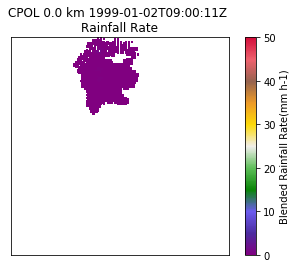

In [29]:
the_grid = pyart.io.read_grid(rad_list[197])
disp = pyart.graph.GridMapDisplay(the_grid)
lats = the_grid.point_latitude['data'][0]
lons = the_grid.point_longitude['data'][0]
disp.plot_grid('radar_estimated_rain_rate')

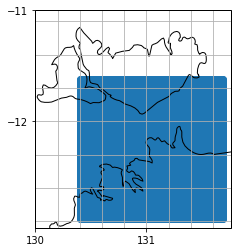

In [30]:
axis = plt.axes(projection=ccrs.PlateCarree())
axis.scatter(lons, lats)
axis.coastlines(resolution='10m')
axis.gridlines()
axis.set_xticks([130, 131])
axis.set_yticks([-12, -11])

In [31]:
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep

land_shp_fname = shpreader.natural_earth(resolution='10m',
                                       category='physical', name='land')

land_geom = unary_union(list(shpreader.Reader(land_shp_fname).geometries()))
land = prep(land_geom)

def is_land(x, y):
    return land.contains(sgeom.Point(x, y))

In [32]:
land_mask = np.zeros(lats.shape)
for i in range(lats.shape[0]):
    for j in range(lons.shape[0]):
        land_mask[i,j] = is_land(lons[i,j], lats[i,j])

land_mask[np.logical_and(lats>-12, land_mask == 1)] = 2

AttributeError: 'Colorbar' object has no attribute 'set_yticklabels'

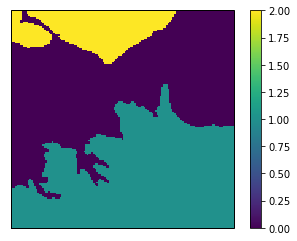

In [33]:
axis = plt.axes(projection=ccrs.PlateCarree())
mesh = axis.pcolormesh(lons, lats, land_mask)
ax = plt.colorbar(mesh, ax=axis)
ax.set_yticklabels(['Ocean', 'Main Continent', 'Tiwi Island'])

In [34]:
# 0 = ocean, 1 = land, 2 = Tiwi Islands
def get_rainfall_spatial_variability_mask(file, land_mask, value):
    Grid = pyart.io.read_grid(file, exclude_fields=exclude_fields)
    print(Grid.time['data'])
    rain_rate = Grid.fields['radar_estimated_rain_rate']['data']
    rain_rate = rain_rate[3]
    rain_rate = np.ma.masked_where(np.logical_or(land_mask != value,
                                                 rain_rate < 0.1), rain_rate)
    rain_rate = np.ma.filled(rain_rate, np.nan)
    pixel_area = 1
    rr_x = np.arange(1.0, 150, 1.0)
    N_rainrate, A_rainrate, Rm_rainrate = area_anal(pixel_area, rr_x, rain_rate)
    del Grid
    return N_rainrate, A_rainrate, Rm_rainrate

%time get_rainfall_spatial_variability_mask(rad_list[197], land_mask, 1)

[9.0]
CPU times: user 206 ms, sys: 7.8 ms, total: 214 ms
Wall time: 259 ms


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.

In [ ]:
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=36, project='rainfall', walltime='0:30:00', 
                       job_cpu=36, memory='128GB', processes=18)

cluster.scale(256)         # Ask for ten workers

from dask.distributed import Client
client = Client(cluster)  # Connect this local process to remote workers

# wait for jobs to arrive, depending on the queue, this may take some time

import dask.array as da

In [ ]:
client

In [ ]:
#Stop the cluster with this line after analysis is done!
cluster.stop_all_jobs()

In [ ]:
# Load all of the data

mjo_index = []
N = []
A = []
Rm = []
dros_index = []
mjo_index = []
for the_year in year_list:
    print('Loading year ' + the_year)
    rad_list = glob(('/lcrc/group/earthscience/radar/CPOL_level_1b/GRIDDED/GRID_70km_1000m/' + the_year + '/**/*.nc'), 
                    recursive=True)
    rad_list = sorted(rad_list)
    the_bag = db.from_sequence(rad_list, npartitions=268)
    get_rainfall = lambda x: get_rainfall_spatial_variability_mask(x, land_mask, 2)
    %time outs = the_bag.map(get_rainfall).compute()
    N.append(np.stack([x[0] for x in outs]))
    A.append(np.stack([x[1] for x in outs]))
    Rm.append(np.stack([x[2] for x in outs]))
    time_list = np.array([parse_time(x) for x in rad_list])
    dros_index.append(np.array([get_dros_class(x) for x in time_list]))
    mjo_index.append(np.array([get_mjo_index(x) for x in time_list]))

dros_index = np.concatenate(dros_index)
mjo_index = np.concatenate(mjo_index)
N = np.concatenate(N, axis=0)
A = np.concatenate(A, axis=0)
Rm = np.concatenate(Rm, axis=0)

In [9]:
time_list = []

for the_year in year_list:
    print('Loading year ' + the_year)
    rad_list = glob(('/lcrc/group/earthscience/radar/CPOL_level_1b/GRIDDED/GRID_70km_1000m/' + the_year + '/**/*.nc'), 
                    recursive=True)
    rad_list = sorted(rad_list)
    time_list.append(np.array([parse_time(x) for x in rad_list]))

time_list = np.concatenate(time_list)
time_list = list(time_list)
#new_ds = xarray.Dataset({'dros_index': (['time'],dros_index),
#                         'mjo_index': (['time'],mjo_index),
#                         'N': (['time', 'x'], N),
#                         'a': (['time', 'x'], A),
#                         'Rm': (['time', 'x'], Rm)}, coords={'time': time_list, 
#                                        'x': np.arange(1.0, 150, 1.0)})
#new_ds.to_netcdf('rain_rate_hists_tiwi.nc')

Loading year 1998
Loading year 1999
Loading year 2000
Loading year 2001
Loading year 2002
Loading year 2003
Loading year 2004
Loading year 2005
Loading year 2006
Loading year 2007
Loading year 2009
Loading year 2010
Loading year 2011
Loading year 2012
Loading year 2013
Loading year 2014
Loading year 2015
Loading year 2016
Loading year 2017


In [ ]:
new_ds = xarray.open_dataset('rain_rate_hists_ocean.nc')

In [ ]:
N = new_ds.N.values
A = new_ds.a.values
Rm = new_ds.Rm.values
dros_index = new_ds.dros_index.values
mjo_index = new_ds.mjo_index.values
new_ds

In [ ]:
hours = np.array([x.hour for x in time_list])
# Convert hours to local time
hours = hours + 9.5
hours[hours > 24] = hours[hours > 24] - 24
num_sum_mjo_inactive = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
area_sum_mjo_inactive = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
num_sum_mjo_active = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
area_sum_mjo_active = np.zeros((24, len(np.arange(1.0, 150, 1.0))))

mjo_inactive = np.logical_or(mjo_index < 4, mjo_index == 8)
for i in range(24):
    inds = np.logical_and.reduce((mjo_inactive, hours >= i, hours < i+1))
    num_scans = len(np.where(inds)[0])
    num_sum_mjo_inactive[i] = np.sum(N[inds,:], axis=0)/num_scans
    area_sum_mjo_inactive[i] = np.sum(A[inds,:], axis=0)/num_scans        
    inds = np.logical_and.reduce((~mjo_inactive, hours >= i, hours < i+1))
    num_scans = len(np.where(inds)[0])
    num_sum_mjo_active[i] = np.sum(N[inds,:], axis=0)/num_scans
    area_sum_mjo_active[i] = np.sum(A[inds,:], axis=0)/num_scans        

x, y = np.meshgrid(np.arange(0,24,1), np.arange(1.0, 150, 1.0))
fig, axes = plt.subplots(2,2, figsize=(15,15))
h = axes[0,0].pcolormesh(x,y,np.log10(num_sum_mjo_inactive.T), cmap='coolwarm', vmin=-2, vmax=2)
cs = axes[0,0].contour(x,y,np.log10(num_sum_mjo_inactive.T), levels=[0], color='k', linewidths=3,
                      linestyles='-')
cs = axes[0,0].contour(x,y,np.log10(num_sum_mjo_inactive.T), levels=[1], color='k', linewidths=3,
                      linestyles='--')
cs = axes[0,0].contour(x,y,np.log10(num_sum_mjo_inactive.T), levels=[-1], color='k', linewidths=3,
                      linestyles='--')
#axes[0].clim([-2,1])
ax = plt.colorbar(h, ax=axes[0,0], label='Number of counts/number of scans')
ax.set_ticks([-2, -1, 0, 1, 2])
ax.set_ticklabels(['0.01', '0.1', '1', '10', '100'])
axes[0,0].set_ylabel('Rainfall rate [mm/hr]')
axes[0,0].set_title('MJO inactive')
axes[0,0].set_xlabel('Time [local]')

h = axes[1,0].pcolormesh(x,y,np.log10(num_sum_mjo_active.T), cmap='coolwarm', vmin=-2, vmax=2)
#axes[1].clim([-2,1])
ax = plt.colorbar(h, ax=axes[1,0], label='Number of counts/number of scans')
cs = axes[1,0].contour(x,y,np.log10(num_sum_mjo_active.T), levels=[0], color='k', linewidths=3,
                      linestyles='-')
cs = axes[1,0].contour(x,y,np.log10(num_sum_mjo_active.T), levels=[1], color='k', linewidths=3,
                      linestyles='--')
cs = axes[1,0].contour(x,y,np.log10(num_sum_mjo_active.T), levels=[-1], color='k', linewidths=3,
                      linestyles='--')
ax.set_ticks([-2, -1, 0, 1, 2])
ax.set_ticklabels(['0.01', '0.1', '1', '10', '100'])
axes[1,0].set_ylabel('Rainfall rate [mm/hr]')
axes[1,0].set_title('MJO active')
axes[1,0].set_xlabel('Time [local]')

h = axes[0,1].pcolormesh(x,y,np.log10(area_sum_mjo_inactive.T), cmap='coolwarm', vmin=-2, vmax=3)
#axes[1].clim([-2,1])
ax = plt.colorbar(h, ax=axes[0,1], label='Area [$km^2$]/number of scans')
cs = axes[0,1].contour(x,y,np.log10(area_sum_mjo_inactive.T), levels=[0], color='k', linewidths=3,
                      linestyles='-')
cs = axes[0,1].contour(x,y,np.log10(area_sum_mjo_inactive.T), levels=[1], color='k', linewidths=3,
                      linestyles='--')
cs = axes[0,1].contour(x,y,np.log10(area_sum_mjo_inactive.T), levels=[-1], color='k', linewidths=3,
                      linestyles='--')
ax.set_ticks([-2, -1, 0, 1, 2, 3])
ax.set_ticklabels(['0.01', '0.1', '1', '10', '100', '1000'])
axes[0,1].set_ylabel('Rainfall rate [mm/hr]')
axes[0,1].set_title('MJO inactive')
axes[0,1].set_xlabel('Time [local]')

h = axes[1,1].pcolormesh(x,y,np.log10(area_sum_mjo_active.T), cmap='coolwarm', vmin=-2, vmax=3)
cs = axes[1,1].contour(x,y,np.log10(area_sum_mjo_active.T), levels=[0], color='k', linewidths=3,
                      linestyles='-')
cs = axes[1,1].contour(x,y,np.log10(area_sum_mjo_active.T), levels=[1], color='k', linewidths=3,
                      linestyles='--')
cs = axes[1,1].contour(x,y,np.log10(area_sum_mjo_active.T), levels=[-1], color='k', linewidths=3,
                      linestyles='--')
#axes[1].clim([-2,1])
ax = plt.colorbar(h, ax=axes[1,1], label='Area [$km^2$]/number of scans')
ax.set_ticks([-2, -1, 0, 1, 2, 3])
ax.set_ticklabels(['0.01', '0.1', '1', '10', '100', '1000'])
axes[1,1].set_ylabel('Rainfall rate [mm/hr]')
axes[1,1].set_title('MJO active')
axes[1,1].set_xlabel('Time [local]')

In [10]:
hours = np.array([x.hour for x in time_list])
# Convert hours to local time
hours = hours + 9.5
hours[hours > 24] = hours[hours > 24] - 24
num_sum_mjo_inactive = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
area_sum_mjo_inactive = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
num_sum_mjo_active = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
area_sum_mjo_active = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
print(len(hours))

for i in range(24):
    inds = np.logical_and.reduce((dros_index == 0, hours >= i, hours < i+1))
    num_scans = len(np.where(inds)[0])
    num_sum_mjo_inactive[i] = np.sum(N[inds,:], axis=0)/num_scans
    area_sum_mjo_inactive[i] = np.sum(A[inds,:], axis=0)/num_scans        
    inds = np.logical_and.reduce((dros_index == 1, hours >= i, hours < i+1))
    num_scans = len(np.where(inds)[0])
    num_sum_mjo_active[i] = np.sum(N[inds,:], axis=0)/num_scans
    area_sum_mjo_active[i] = np.sum(A[inds,:], axis=0)/num_scans        

x, y = np.meshgrid(np.arange(0,24,1), np.arange(1.0, 150, 1.0))
fig, axes = plt.subplots(2,2, figsize=(15,15))
h = axes[0,0].pcolormesh(x,y,np.log10(num_sum_mjo_inactive.T), cmap='coolwarm', vmin=-2, vmax=2)
cs = axes[0,0].contour(x,y,np.log10(num_sum_mjo_inactive.T), levels=[0], color='k', linewidths=3,
                      linestyles='-')
cs = axes[0,0].contour(x,y,np.log10(num_sum_mjo_inactive.T), levels=[1], color='k', linewidths=3,
                      linestyles='--')
cs = axes[0,0].contour(x,y,np.log10(num_sum_mjo_inactive.T), levels=[-1], color='k', linewidths=3,
                      linestyles='--')
#axes[0].clim([-2,1])
ax = plt.colorbar(h, ax=axes[0,0], label='Number of counts/number of scans')
ax.set_ticks([-2, -1, 0, 1, 2])
ax.set_ticklabels(['0.01', '0.1', '1', '10', '100'])
axes[0,0].set_ylabel('Rainfall rate [mm/hr]')
axes[0,0].set_title('Break')
axes[0,0].set_xlabel('Time [local]')

h = axes[1,0].pcolormesh(x,y,np.log10(num_sum_mjo_active.T), cmap='coolwarm', vmin=-2, vmax=2)
#axes[1].clim([-2,1])
ax = plt.colorbar(h, ax=axes[1,0], label='Number of counts/number of scans')
cs = axes[1,0].contour(x,y,np.log10(num_sum_mjo_active.T), levels=[0], color='k', linewidths=3,
                      linestyles='-')
cs = axes[1,0].contour(x,y,np.log10(num_sum_mjo_active.T), levels=[1], color='k', linewidths=3,
                      linestyles='--')
cs = axes[1,0].contour(x,y,np.log10(num_sum_mjo_active.T), levels=[-1], color='k', linewidths=3,
                      linestyles='--')
ax.set_ticks([-2, -1, 0, 1, 2])
ax.set_ticklabels(['0.01', '0.1', '1', '10', '100'])
axes[1,0].set_ylabel('Rainfall rate [mm/hr]')
axes[1,0].set_title('Monsoon')
axes[1,0].set_xlabel('Time [local]')

h = axes[0,1].pcolormesh(x,y,np.log10(area_sum_mjo_inactive.T), cmap='coolwarm', vmin=-2, vmax=3)
#axes[1].clim([-2,1])
ax = plt.colorbar(h, ax=axes[0,1], label='Area [$km^2$]/number of scans')
cs = axes[0,1].contour(x,y,np.log10(area_sum_mjo_inactive.T), levels=[0], color='k', linewidths=3,
                      linestyles='-')
cs = axes[0,1].contour(x,y,np.log10(area_sum_mjo_inactive.T), levels=[1], color='k', linewidths=3,
                      linestyles='--')
cs = axes[0,1].contour(x,y,np.log10(area_sum_mjo_inactive.T), levels=[-1], color='k', linewidths=3,
                      linestyles='--')
ax.set_ticks([-2, -1, 0, 1, 2, 3])
ax.set_ticklabels(['0.01', '0.1', '1', '10', '100', '1000'])
axes[0,1].set_ylabel('Rainfall rate [mm/hr]')
axes[0,1].set_title('Break')
axes[0,1].set_xlabel('Time [local]')

h = axes[1,1].pcolormesh(x,y,np.log10(area_sum_mjo_active.T), cmap='coolwarm', vmin=-2, vmax=3)
cs = axes[1,1].contour(x,y,np.log10(area_sum_mjo_active.T), levels=[0], color='k', linewidths=3,
                      linestyles='-')
cs = axes[1,1].contour(x,y,np.log10(area_sum_mjo_active.T), levels=[1], color='k', linewidths=3,
                      linestyles='--')
cs = axes[1,1].contour(x,y,np.log10(area_sum_mjo_active.T), levels=[-1], color='k', linewidths=3,
                      linestyles='--')
#axes[1].clim([-2,1])
ax = plt.colorbar(h, ax=axes[1,1], label='Area [$km^2$]/number of scans')
ax.set_ticks([-2, -1, 0, 1, 2, 3])
ax.set_ticklabels(['0.01', '0.1', '1', '10', '100', '1000'])
axes[1,1].set_ylabel('Rainfall rate [mm/hr]')
axes[1,1].set_title('Monsoon')
axes[1,1].set_xlabel('Time [local]')

356726


ValueError: setting an array element with a sequence.

In [178]:
ds_ocean = xarray.open_dataset('rain_rate_hists_ocean.nc')
ds_land = xarray.open_dataset('rain_rate_hists_land.nc')
ds_tiwi = xarray.open_dataset('rain_rate_hists_tiwi.nc')
ds_tiwi

<xarray.Dataset>
Dimensions:     (time: 356726, x: 149)
Coordinates:
  * time        (time) datetime64[ns] 1998-12-06T06:30:00 ...
  * x           (x) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...
Data variables:
    dros_index  (time) float64 ...
    mjo_index   (time) float64 ...
    N           (time, x) float64 ...
    a           (time, x) float64 ...
    Rm          (time, x) float64 ...

In [179]:
area_tiwi = ds_tiwi.a.values
area_ocean = ds_ocean.a.values
area_land = ds_land.a.values

mean_tiwi = ds_tiwi.Rm.values 
mean_ocean = ds_ocean.Rm.values
mean_land = ds_land.Rm.values
dros_index = ds_land.dros_index.values
mjo_index = ds_land.mjo_index.values

area_tiwi_gt100 = area_tiwi[:,100]
area_ocean_gt100 = area_ocean[:,100]
area_land_gt100 = area_land[:,100]

area_mjo_inactive_tiwi = np.zeros((24))
area_mjo_active_tiwi = np.zeros((24))
area_mjo_inactive_land = np.zeros((24))
area_mjo_active_land = np.zeros((24))
area_mjo_inactive_ocean = np.zeros((24))
area_mjo_active_ocean = np.zeros((24))

print(area_tiwi_gt100.shape)

for i in range(24):
    inds = np.logical_and.reduce((dros_index == 0, hours >= i, hours < i+1))
    num_scans = len(np.where(inds)[0])
    area_mjo_inactive_tiwi[i] = np.nanmean(area_tiwi_gt100[inds])/np.sum(land_mask == 2)
    area_mjo_inactive_land[i] = np.nanmean(area_land_gt100[inds])/np.sum(land_mask == 1)
    area_mjo_inactive_ocean[i] = np.nanmean(area_ocean_gt100[inds])/np.sum(land_mask == 0)
    inds = np.logical_and.reduce((dros_index == 1, hours >= i, hours < i+1))
    num_scans = len(np.where(inds)[0])
    area_mjo_active_tiwi[i] = np.nanmean(area_tiwi_gt100[inds])/np.sum(land_mask == 2)
    area_mjo_active_land[i] = np.nanmean(area_land_gt100[inds])/np.sum(land_mask == 1)
    area_mjo_active_ocean[i] = np.nanmean(area_ocean_gt100[inds])/np.sum(land_mask == 0)

(356726,)


NameError: name 'hours' is not defined

<input>:9: DeprecationWarning: invalid escape sequence \ 
<input>:9: DeprecationWarning: invalid escape sequence \ 
<input>:9: DeprecationWarning: invalid escape sequence \ 
<ipython-input-26-2cb7bb4d9eab>:9: DeprecationWarning: invalid escape sequence \ 
  plt.ylabel('Normalized Area of R > 100 $mm\ hr^{-1}$ [$km^{2}$]')


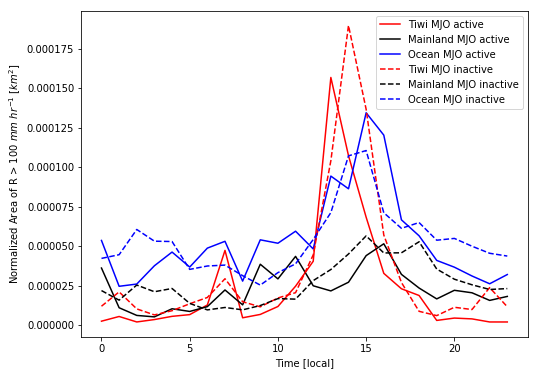

In [26]:
plt.figure(figsize=(8,6))
plt.plot(range(24), area_mjo_active_tiwi, color='r', label='Tiwi MJO active')
plt.plot(range(24), area_mjo_active_land, color='k', label='Mainland MJO active')
plt.plot(range(24), area_mjo_active_ocean, color='b', label='Ocean MJO active')
plt.plot(range(24), area_mjo_inactive_tiwi, color='r', linestyle='--', label='Tiwi MJO inactive')
plt.plot(range(24), area_mjo_inactive_land, color='k', linestyle='--', label='Mainland MJO inactive')
plt.plot(range(24), area_mjo_inactive_ocean, color='b', linestyle='--', label='Ocean MJO inactive')
plt.xlabel('Time [local]')
plt.ylabel('Normalized Area of R > 100 $mm\ hr^{-1}$ [$km^{2}$]')
plt.legend()

In [ ]:
def RMSE_blended(rr):
    return 0.51*rr**0.82

In [ ]:
Rm_tiwi = ds_tiwi.Rm.values
Rm_land = ds_land.Rm.values
Rm_ocean = ds_ocean.Rm.values
bins = ds_tiwi.x

plt.errorbar(bins, np.nanmean(Rm_tiwi, axis=0), yerr=RMSE_blended(np.nanmean(Rm_tiwi, axis=0)),label='Tiwi Islands')
plt.errorbar(bins, np.nanmean(Rm_land, axis=0), yerr=RMSE_blended(np.nanmean(Rm_land, axis=0)), label='Mainland Australia')
plt.errorbar(bins, np.nanmean(Rm_ocean, axis=0), yerr=RMSE_blended(np.nanmean(Rm_ocean, axis=0)), label='Ocean')
plt.legend()
plt.xlabel('Rainfall rate [$mm\ hr^{-1}$]')
plt.ylabel('Mean rainfall rate > R [$mm\ hr^{-1}$]')

In [ ]:
hours = np.array([x.hour for x in time_list])
# Convert hours to local time
hours = hours + 9.5
hours[hours > 24] = hours[hours > 24] - 24
num_sum_mjo_inactive_tiwi = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
num_sum_mjo_active_tiwi = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
num_sum_mjo_inactive_land = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
num_sum_mjo_active_land = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
num_sum_mjo_inactive_ocean = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
num_sum_mjo_active_ocean = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
print(len(hours))

for i in range(24):
    inds = np.logical_and.reduce((dros_index == 0, hours >= i, hours < i+1))
    num_scans = len(np.where(inds)[0])
    num_sum_mjo_inactive_tiwi[i] = np.nanmean(Rm_tiwi[inds,:], axis=0)
    num_sum_mjo_inactive_land[i] = np.nanmean(Rm_land[inds,:], axis=0)
    num_sum_mjo_inactive_ocean[i] = np.nanmean(Rm_ocean[inds,:], axis=0)
    inds = np.logical_and.reduce((dros_index == 1, hours >= i, hours < i+1))
    num_scans = len(np.where(inds)[0])
    num_sum_mjo_active_tiwi[i] = np.nanmean(Rm_tiwi[inds,:], axis=0)
    num_sum_mjo_active_land[i] = np.nanmean(Rm_land[inds,:], axis=0)
    num_sum_mjo_active_ocean[i] = np.nanmean(Rm_ocean[inds,:], axis=0)

x, y = np.meshgrid(np.arange(0,24,1), np.arange(1.0, 150, 1.0))
fig, axes = plt.subplots(2,3, figsize=(25,15))
h = axes[0,0].pcolormesh(x,y,num_sum_mjo_inactive_tiwi.T, cmap='coolwarm', vmin=0, vmax=200)
cs = axes[0,0].contour(x,y,num_sum_mjo_inactive_tiwi.T, levels=[100], color='k', linewidths=3,
                      linestyles='-')
cs = axes[0,0].contour(x,y,num_sum_mjo_inactive_tiwi.T, levels=[50], color='k', linewidths=3,
                      linestyles='--')
cs = axes[0,0].contour(x,y,num_sum_mjo_inactive_tiwi.T, levels=[150], color='k', linewidths=3,
                      linestyles='--')
#axes[0].clim([-2,1])
ax = plt.colorbar(h, ax=axes[0,0], label='Mean rainfall rate for regions > R')
axes[0,0].set_ylabel('Rainfall rate [mm/hr]')
axes[0,0].set_title('Break (Tiwi Islands)')
axes[0,0].set_xlabel('Time [local]')

h = axes[1,0].pcolormesh(x,y,num_sum_mjo_active_tiwi.T, cmap='coolwarm', vmin=0, vmax=200)
#axes[1].clim([-2,1])
ax = plt.colorbar(h, ax=axes[1,0], label='Number of counts/number of scans')
cs = axes[1,0].contour(x,y,num_sum_mjo_active_tiwi.T, levels=[100], color='k', linewidths=3,
                      linestyles='-')
cs = axes[1,0].contour(x,y,num_sum_mjo_active_tiwi.T, levels=[50], color='k', linewidths=3,
                      linestyles='--')
cs = axes[1,0].contour(x,y,num_sum_mjo_active_tiwi.T, levels=[150], color='k', linewidths=3,
                      linestyles='--')
axes[1,0].set_ylabel('Rainfall rate [mm/hr]')
axes[1,0].set_title('Monsoon (Tiwi Islands)')
axes[1,0].set_xlabel('Time [local]')

h = axes[0,1].pcolormesh(x,y,num_sum_mjo_inactive_land.T, cmap='coolwarm', vmin=0, vmax=200)
cs = axes[0,1].contour(x,y,num_sum_mjo_inactive_land.T, levels=[100], color='k', linewidths=3,
                      linestyles='-')
cs = axes[0,1].contour(x,y,num_sum_mjo_inactive_land.T, levels=[50], color='k', linewidths=3,
                      linestyles='--')
cs = axes[0,1].contour(x,y,num_sum_mjo_inactive_land.T, levels=[150], color='k', linewidths=3,
                      linestyles='--')
#axes[0].clim([-2,1])
ax = plt.colorbar(h, ax=axes[0,1], label='Mean rainfall rate for regions > R')
axes[0,1].set_ylabel('Rainfall rate [mm/hr]')
axes[0,1].set_title('Break (Mainland Australia)')
axes[0,1].set_xlabel('Time [local]')

h = axes[1,1].pcolormesh(x,y,num_sum_mjo_active_land.T, cmap='coolwarm', vmin=0, vmax=200)
#axes[1].clim([-2,1])
ax = plt.colorbar(h, ax=axes[1,1], label='Number of counts/number of scans')
cs = axes[1,1].contour(x,y,num_sum_mjo_active_land.T, levels=[100], color='k', linewidths=3,
                      linestyles='-')
cs = axes[1,1].contour(x,y,num_sum_mjo_active_land.T, levels=[50], color='k', linewidths=3,
                      linestyles='--')
cs = axes[1,1].contour(x,y,num_sum_mjo_active_land.T, levels=[150], color='k', linewidths=3,
                      linestyles='--')
axes[1,1].set_ylabel('Rainfall rate [mm/hr]')
axes[1,1].set_title('Monsoon (Mainland Australia)')
axes[1,1].set_xlabel('Time [local]')

h = axes[0,2].pcolormesh(x,y,num_sum_mjo_inactive_ocean.T, cmap='coolwarm', vmin=0, vmax=200)
cs = axes[0,2].contour(x,y,num_sum_mjo_inactive_ocean.T, levels=[100], color='k', linewidths=3,
                      linestyles='-')
cs = axes[0,2].contour(x,y,num_sum_mjo_inactive_ocean.T, levels=[50], color='k', linewidths=3,
                      linestyles='--')
cs = axes[0,2].contour(x,y,num_sum_mjo_inactive_ocean.T, levels=[150], color='k', linewidths=3,
                      linestyles='--')
#axes[0].clim([-2,1])
ax = plt.colorbar(h, ax=axes[0,2], label='Mean rainfall rate for regions > R')
axes[0,2].set_ylabel('Rainfall rate [mm/hr]')
axes[0,2].set_title('Break (Ocean)')
axes[0,2].set_xlabel('Time [local]')

h = axes[1,2].pcolormesh(x,y,num_sum_mjo_active_ocean.T, cmap='coolwarm', vmin=0, vmax=200)
#axes[1].clim([-2,1])
ax = plt.colorbar(h, ax=axes[1,2], label='Number of counts/number of scans')
cs = axes[1,2].contour(x,y,num_sum_mjo_active_ocean.T, levels=[100], color='k', linewidths=3,
                      linestyles='-')
cs = axes[1,2].contour(x,y,num_sum_mjo_active_ocean.T, levels=[50], color='k', linewidths=3,
                      linestyles='--')
cs = axes[1,2].contour(x,y,num_sum_mjo_active_ocean.T, levels=[150], color='k', linewidths=3,
                      linestyles='--')
axes[1,2].set_ylabel('Rainfall rate [mm/hr]')
axes[1,2].set_title('Monsoon (Ocean)')
axes[1,2].set_xlabel('Time [local]')

In [ ]:
hours = np.array([x.hour for x in time_list])
# Convert hours to local time
hours = hours + 9.5
hours[hours > 24] = hours[hours > 24] - 24
num_sum_mjo_inactive_tiwi = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
num_sum_mjo_active_tiwi = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
num_sum_mjo_inactive_land = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
num_sum_mjo_active_land = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
num_sum_mjo_inactive_ocean = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
num_sum_mjo_active_ocean = np.zeros((24, len(np.arange(1.0, 150, 1.0))))
print(len(hours))
mjo_inactive = np.logical_or(mjo_index < 4, mjo_index == 8)

for i in range(24):
    inds = np.logical_and.reduce((mjo_inactive, hours >= i, hours < i+1))
    num_scans = len(np.where(inds)[0])
    num_sum_mjo_inactive_tiwi[i] = np.nanmean(Rm_tiwi[inds,:], axis=0)
    num_sum_mjo_inactive_land[i] = np.nanmean(Rm_land[inds,:], axis=0)
    num_sum_mjo_inactive_ocean[i] = np.nanmean(Rm_ocean[inds,:], axis=0)
    inds = np.logical_and.reduce((~mjo_inactive, hours >= i, hours < i+1))
    num_scans = len(np.where(inds)[0])
    num_sum_mjo_active_tiwi[i] = np.nanmean(Rm_tiwi[inds,:], axis=0)
    num_sum_mjo_active_land[i] = np.nanmean(Rm_land[inds,:], axis=0)
    num_sum_mjo_active_ocean[i] = np.nanmean(Rm_ocean[inds,:], axis=0)

x, y = np.meshgrid(np.arange(0,24,1), np.arange(1.0, 150, 1.0))
fig, axes = plt.subplots(2,3, figsize=(25,15))
h = axes[0,0].contourf(x,y,num_sum_mjo_inactive_tiwi.T, cmap='coolwarm', levels=np.arange(0,250,10))
cs = axes[0,0].contour(x,y,num_sum_mjo_inactive_tiwi.T, levels=[100], color='k', linewidths=3,
                      linestyles='-')
cs = axes[0,0].contour(x,y,num_sum_mjo_inactive_tiwi.T, levels=[50], color='k', linewidths=3,
                      linestyles='--')
cs = axes[0,0].contour(x,y,num_sum_mjo_inactive_tiwi.T, levels=[150], color='k', linewidths=3,
                      linestyles='--')
#axes[0].clim([-2,1])
ax = plt.colorbar(h, ax=axes[0,0], label='Mean rainfall rate for regions > R')
axes[0,0].set_ylabel('Rainfall rate [mm/hr]')
axes[0,0].set_title('MJO inactive (Tiwi Islands)')
axes[0,0].set_xlabel('Time [local]')

h = axes[1,0].contourf(x,y,num_sum_mjo_active_tiwi.T, cmap='coolwarm', levels=np.arange(0,250,10))
#axes[1].clim([-2,1])
ax = plt.colorbar(h, ax=axes[1,0], label='Number of counts/number of scans')
cs = axes[1,0].contour(x,y,num_sum_mjo_active_tiwi.T, levels=[100], color='k', linewidths=3,
                      linestyles='-')
cs = axes[1,0].contour(x,y,num_sum_mjo_active_tiwi.T, levels=[50], color='k', linewidths=3,
                      linestyles='--')
cs = axes[1,0].contour(x,y,num_sum_mjo_active_tiwi.T, levels=[150], color='k', linewidths=3,
                      linestyles='--')
axes[1,0].set_ylabel('Rainfall rate [mm/hr]')
axes[1,0].set_title('MJO active (Tiwi Islands)')
axes[1,0].set_xlabel('Time [local]')

h = axes[0,1].pcolormesh(x,y,num_sum_mjo_inactive_land.T, cmap='coolwarm', vmin=0, vmax=200)
cs = axes[0,1].contour(x,y,num_sum_mjo_inactive_land.T, levels=[100], color='k', linewidths=3,
                      linestyles='-')
cs = axes[0,1].contour(x,y,num_sum_mjo_inactive_land.T, levels=[50], color='k', linewidths=3,
                      linestyles='--')
cs = axes[0,1].contour(x,y,num_sum_mjo_inactive_land.T, levels=[150], color='k', linewidths=3,
                      linestyles='--')
#axes[0].clim([-2,1])
ax = plt.colorbar(h, ax=axes[0,1], label='Mean rainfall rate for regions > R')
axes[0,1].set_ylabel('Rainfall rate [mm/hr]')
axes[0,1].set_title('MJO inactive (Mainland Australia)')
axes[0,1].set_xlabel('Time [local]')

h = axes[1,1].pcolormesh(x,y,num_sum_mjo_active_land.T, cmap='coolwarm', vmin=0, vmax=200)
#axes[1].clim([-2,1])
ax = plt.colorbar(h, ax=axes[1,1], label='Number of counts/number of scans')
cs = axes[1,1].contour(x,y,num_sum_mjo_active_land.T, levels=[100], color='k', linewidths=3,
                      linestyles='-')
cs = axes[1,1].contour(x,y,num_sum_mjo_active_land.T, levels=[50], color='k', linewidths=3,
                      linestyles='--')
cs = axes[1,1].contour(x,y,num_sum_mjo_active_land.T, levels=[150], color='k', linewidths=3,
                      linestyles='--')
axes[1,1].set_ylabel('Rainfall rate [mm/hr]')
axes[1,1].set_title('MJO active (Mainland Australia)')
axes[1,1].set_xlabel('Time [local]')

h = axes[0,2].pcolormesh(x,y,num_sum_mjo_inactive_ocean.T, cmap='coolwarm', vmin=0, vmax=200)
cs = axes[0,2].contour(x,y,num_sum_mjo_inactive_ocean.T, levels=[100], color='k', linewidths=3,
                      linestyles='-')
cs = axes[0,2].contour(x,y,num_sum_mjo_inactive_ocean.T, levels=[50], color='k', linewidths=3,
                      linestyles='--')
cs = axes[0,2].contour(x,y,num_sum_mjo_inactive_ocean.T, levels=[150], color='k', linewidths=3,
                      linestyles='--')
#axes[0].clim([-2,1])
ax = plt.colorbar(h, ax=axes[0,2], label='Mean rainfall rate for regions > R')
axes[0,2].set_ylabel('Rainfall rate [mm/hr]')
axes[0,2].set_title('MJO inactive (Ocean)')
axes[0,2].set_xlabel('Time [local]')

h = axes[1,2].pcolormesh(x,y,num_sum_mjo_active_ocean.T, cmap='coolwarm', vmin=0, vmax=200)
#axes[1].clim([-2,1])
ax = plt.colorbar(h, ax=axes[1,2], label='Number of counts/number of scans')
cs = axes[1,2].contour(x,y,num_sum_mjo_active_ocean.T, levels=[100], color='k', linewidths=3,
                      linestyles='-')
cs = axes[1,2].contour(x,y,num_sum_mjo_active_ocean.T, levels=[50], color='k', linewidths=3,
                      linestyles='--')
cs = axes[1,2].contour(x,y,num_sum_mjo_active_ocean.T, levels=[150], color='k', linewidths=3,
                      linestyles='--')
axes[1,2].set_ylabel('Rainfall rate [mm/hr]')
axes[1,2].set_title('MJO active (Ocean)')
axes[1,2].set_xlabel('Time [local]')

## Get daily rainfall over Darwin

In [35]:
excluded_fields = ['radar_echo_classification', 'NW', 'velocity_texture',  
                   'cross_correlation_ratio', 'temperature', 'corrected_differential_reflectivity', 
                   'region_dealias_velocity', 'total_power', 'velocity', 'D0', 'reflectivity', 'ROI', 'longitude', 'latitude']
def get_daily_rainfall(date, level):
    the_year = "%04d" % date.year
    the_month = "%02d" % date.month
    the_day = "%02d" % date.day
    print(date)
    rad_list = glob(('/lcrc/group/earthscience/radar/CPOL_level_1b/GRIDDED/GRID_70km_1000m/' + the_year + '/' + 
                     the_year + the_month + the_day + '/*.nc'), 
                    recursive=True)
    rad_list = sorted(rad_list)
    radar = pyart.io.read_grid(rad_list[0], exclude_fields=excluded_fields)
    rr = radar.fields["radar_estimated_rain_rate"]["data"]/6
    rain_rate = rr.filled(0)
    del radar
    for i in range(1, len(rad_list)):
        radar = pyart.io.read_grid(rad_list[i], exclude_fields=excluded_fields)
        rr = radar.fields["radar_estimated_rain_rate"]["data"]/6
        rain_rate += rr.filled(0)
        del radar
    
    return rain_rate[level]

In [36]:
x= get_daily_rainfall(datetime.date(2006, 1, 20), 2)

2006-01-20


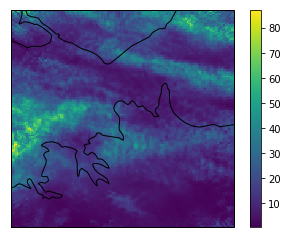

In [37]:
the_grid = pyart.io.read_grid(rad_list[197])
disp = pyart.graph.GridMapDisplay(the_grid)
lats = the_grid.point_latitude['data'][0]
lons = the_grid.point_longitude['data'][0]
ax = plt.axes(projection=ccrs.PlateCarree())
mesh = ax.pcolormesh(lons, lats, x)
plt.colorbar(mesh, ax=ax, cmap='coolwarm')
ax.coastlines(resolution='10m')

In [10]:
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=36, project='rainfall', walltime='1:15:00', 
                       job_cpu=36, memory='128GB', processes=18)

cluster.scale(36)         # Ask for ten workers

from dask.distributed import Client
client = Client(cluster)  # Connect this local process to remote workers

# wait for jobs to arrive, depending on the queue, this may take some time

import dask.array as da

/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/tornado/concurrent.py:521: DeprecationWarning: @return_future is deprecated, use coroutines instead
  DeprecationWarning)


In [87]:
client

Client Scheduler: tcp://140.221.70.6:45431 Dashboard: http://140.221.70.6:8787/status,Cluster Workers: 18 Cores: 36 Memory: 127.98 GB


In [85]:
cluster.scale(18)  

In [82]:
cluster.stop_all_jobs()

In [35]:
yr = 2017
date_list = np.unique([x.date() for x in time_list])
date_list_filtered = date_list[[x.year == yr for x in date_list]]
the_bag = db.from_sequence(date_list_filtered)
rain = lambda x: get_daily_rainfall(x,3)
daily_rain = the_bag.map(rain).compute()

In [36]:
daily_rain = np.stack(daily_rain)
daily_rain.shape

(122, 141, 141)

In [94]:
yr=1998

In [37]:
dros_index_new = np.zeros(daily_rain.shape[0])
mjo_index_new = np.zeros(daily_rain.shape[0])
i = 0
date_list_new = [np.datetime64(x) for x in date_list_filtered]

for days in date_list_filtered:
    dros_index_new[i] = np.median(dros_index[np.where(x.date() == days for x in time_list)[0]])
    mjo_index_new[i] = np.median(mjo_index[np.where(x.date() == days for x in time_list)[0]])
new_ds = xarray.Dataset({'dros_index': (['time'],dros_index_new),
                         'mjo_index': (['time'],mjo_index_new),
                         'daily_rain': (['time', 'x', 'y'], daily_rain),
                         'lats': (['x', 'y'], lats),
                         'lons': (['x', 'y'], lons)},
                          coords={'time': date_list_new, 
                                        'x': np.arange(0, lats.shape[0]), 'y': np.arange(0, lons.shape[1])})
new_ds.to_netcdf(('mean_rr_' + str(yr) + '.nc'))

In [38]:
rr_dataset = xarray.open_mfdataset('mean_rr*.nc')

In [39]:
rr_dataset

<xarray.Dataset>
Dimensions:     (time: 2625, x: 141, y: 141)
Coordinates:
  * x           (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * y           (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * time        (time) datetime64[ns] 1998-12-06 1998-12-07 1998-12-09 ...
Data variables:
    dros_index  (time) float64 dask.array<shape=(2625,), chunksize=(20,)>
    mjo_index   (time) float64 dask.array<shape=(2625,), chunksize=(20,)>
    daily_rain  (time, x, y) float32 dask.array<shape=(2625, 141, 141), chunksize=(20, 141, 141)>
    lats        (time, x, y) float64 dask.array<shape=(2625, 141, 141), chunksize=(20, 141, 141)>
    lons        (time, x, y) float64 dask.array<shape=(2625, 141, 141), chunksize=(20, 141, 141)>

In [40]:
def dt64_to_dt(dt64):
    ts = (dt64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    return datetime.datetime.utcfromtimestamp(ts)

In [363]:
#dros_index = rr_dataset.dros_index.values
#mjo_index = rr_dataset.mjo_index.values
daily_rain = rr_dataset.daily_rain.values
dts = [dt64_to_dt(x) for x in rr_dataset.time.values]
dros_index = np.array([get_dros_class(x) for x in dts])
mjo_index = np.array([get_mjo_index(x) for x in dts])

[[3.56679869 3.51357985 3.49778509 ... 3.13151968 3.2648406  3.37309504]
 [3.76796436 3.44795918 3.37021613 ... 3.09501219 3.17642009 3.23592567]
 [3.66213942 3.49657559 3.54282117 ... 3.42287993 3.34175849 3.34612978]
 ...
 [4.35436225 4.51408672 4.87299323 ... 2.55836248 2.60539174 3.11808896]
 [5.0419457  4.71424055 4.61516142 ... 2.4248457  2.67582119 2.74180293]
 [4.91279221 5.04194093 4.49974203 ... 2.44750667 2.51345444 2.5203979 ]]


Text(0,0.5,'Latitude [$^\\circ$]')

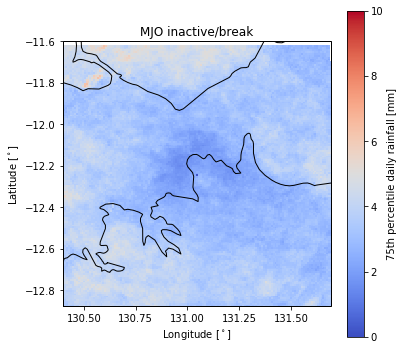

In [177]:
#inds = dros_index == 0
inds = np.logical_and.reduce((dros_index == 0, ~np.logical_or(mjo_index < 3, mjo_index == 8)))
daily_rain[daily_rain == 0] = np.nan
rain = np.nanpercentile(daily_rain[inds,:,:], 50, axis=0)
print(rain)
rain = np.ma.masked_where(rain == 0, rain)
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
mesh = ax.pcolormesh(lons, lats, rain, alpha=1, cmap='coolwarm', vmin=0, vmax=10)
ax2 = plt.colorbar(mesh, ax=ax)
ax2.set_label('75th percentile daily rainfall [mm]')
ax.coastlines(resolution='10m')
ax.set_yticks([-12.8, -12.6, -12.4, -12.2, -12.0, -11.8, -11.6])
ax.set_xticks([130.5, 130.75, 131.0, 131.25, 131.5])
ax.set_title('MJO inactive/break')
ax.set_xlabel('Longitude [$^\circ$]')
ax.set_ylabel('Latitude [$^\circ$]')

In [136]:
#inds = dros_index == 0
rain_range = np.linspace(1, 100, 100)
inds = np.where(np.logical_and(mjo_index > 3, mjo_index < 8))[0]
spatial_inds = np.where(land_mask == 1)
#print(spatial_inds.shape)
rain_array = []
for time_ind in inds:
    for i in range(len(spatial_inds[0])):
        rain_array.append(daily_rain[time_ind, spatial_inds[0][i], spatial_inds[1][i]])

rain_array = np.array(rain_array)
hist_mjo_active_land, bins = np.histogram(rain_array, bins=rain_range, normed=True)

rain_range = np.linspace(1, 100, 100)
inds = np.where(~np.logical_and(mjo_index > 3, mjo_index < 8))[0]
spatial_inds = np.where(land_mask == 1)
#print(spatial_inds.shape)
rain_array = []
for time_ind in inds:
    for i in range(len(spatial_inds[0])):
        rain_array.append(daily_rain[time_ind, spatial_inds[0][i], spatial_inds[1][i]])

rain_array = np.array(rain_array)
hist_mjo_inactive_land, bins = np.histogram(rain_array, bins=rain_range, normed=True)

rain_range = np.linspace(1, 100, 100)
inds = np.where(np.logical_and(mjo_index > 3, mjo_index < 8))[0]
spatial_inds = np.where(land_mask == 0)
#print(spatial_inds.shape)
rain_array = []
for time_ind in inds:
    for i in range(len(spatial_inds[0])):
        rain_array.append(daily_rain[time_ind, spatial_inds[0][i], spatial_inds[1][i]])

rain_array = np.array(rain_array)
hist_mjo_active_ocean, bins = np.histogram(rain_array, bins=rain_range, normed=True)

rain_range = np.linspace(1, 100, 100)
inds = np.where(~np.logical_and(mjo_index > 3, mjo_index < 8))[0]
spatial_inds = np.where(land_mask == 0)
#print(spatial_inds.shape)
rain_array = []
for time_ind in inds:
    for i in range(len(spatial_inds[0])):
        rain_array.append(daily_rain[time_ind, spatial_inds[0][i], spatial_inds[1][i]])

rain_array = np.array(rain_array)
hist_mjo_inactive_ocean, bins = np.histogram(rain_array, bins=rain_range, normed=True)

rain_range = np.linspace(1, 100, 100)
inds = np.where(np.logical_and(mjo_index > 3, mjo_index < 8))[0]
spatial_inds = np.where(land_mask == 2)
#print(spatial_inds.shape)
rain_array = []
for time_ind in inds:
    for i in range(len(spatial_inds[0])):
        rain_array.append(daily_rain[time_ind, spatial_inds[0][i], spatial_inds[1][i]])

rain_array = np.array(rain_array)
hist_mjo_active_tiwi, bins = np.histogram(rain_array, bins=rain_range, normed=True)

rain_range = np.linspace(1, 100, 100)
inds = np.where(~np.logical_and(mjo_index > 3, mjo_index < 8))[0]
spatial_inds = np.where(land_mask == 2)
#print(spatial_inds.shape)
rain_array = []
for time_ind in inds:
    for i in range(len(spatial_inds[0])):
        rain_array.append(daily_rain[time_ind, spatial_inds[0][i], spatial_inds[1][i]])

rain_array = np.array(rain_array)
hist_mjo_inactive_tiwi, bins = np.histogram(rain_array, bins=rain_range, normed=True)

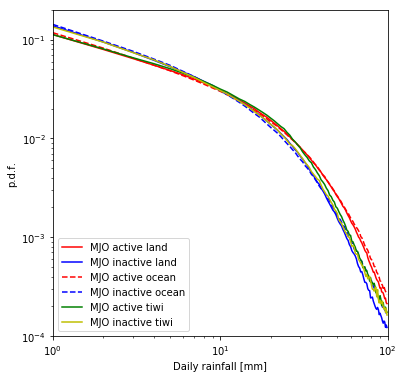

In [151]:
#fig, ax = plt.subplots(1,1,figsize=(6,6))
#ax.plot(bins[:-1], hist_mjo_active_land, label='MJO active land', color='r')
#ax.plot(bins[:-1], hist_mjo_inactive_land, label='MJO inactive land', color='b')
#ax.plot(bins[:-1], hist_mjo_active_ocean, label='MJO active ocean', color='r', linestyle='--')
#ax.plot(bins[:-1], hist_mjo_inactive_ocean, label='MJO inactive ocean', color='b', linestyle='--')
#ax.plot(bins[:-1], hist_mjo_active_tiwi, label='MJO active tiwi', color='g')
#ax.plot(bins[:-1], hist_mjo_inactive_tiwi, label='MJO inactive tiwi', color='y')
#ax.set_xlabel('Daily rainfall [mm]')
#ax.set_ylabel('p.d.f.')
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_ylim([0.0001, 0.2])
#ax.set_xlim([1, 100])
#ax.legend()

## Get diurnal range and peak

In [256]:
excluded_fields = ['radar_echo_classification', 'NW', 'velocity_texture',  
                   'cross_correlation_ratio', 'temperature', 'corrected_differential_reflectivity', 
                   'region_dealias_velocity', 'total_power', 'velocity', 'D0', 'reflectivity', 'ROI', 
                   'longitude', 'latitude']

def get_daily_range(date, level):
    the_year = "%04d" % date.year
    the_month = "%02d" % date.month
    the_day = "%02d" % date.day
    print(date)
    rad_list = glob(('/lcrc/group/earthscience/radar/CPOL_level_1b/GRIDDED/GRID_70km_1000m/' + the_year + '/' + 
                     the_year + the_month + the_day + '/*.nc'), recursive=True)
    rad_list = sorted(rad_list)
    radar = pyart.io.read_grid(rad_list[0], exclude_fields=excluded_fields)
    radtime = datetime.datetime.strptime(radar.time["units"], "seconds since  %Y-%m-%dT%H:%M:%SZ")
    rr = radar.fields["radar_estimated_rain_rate"]["data"][level]
    rain_rate = rr.filled(np.nan)
    rain_array = [rain_rate]
    hours = [radtime.hour]
    for i in range(1, len(rad_list)):
        radar = pyart.io.read_grid(rad_list[i], exclude_fields=excluded_fields)
        rr = radar.fields["radar_estimated_rain_rate"]["data"][level]
        rain_array.append(rr.filled(np.nan))
        radtime = datetime.datetime.strptime(radar.time["units"], "seconds since  %Y-%m-%dT%H:%M:%SZ")
        hours.append(radtime.hour)
        del radar
    rain_array = np.stack(rain_array, axis=0)
    range_array = np.nanmax(rain_array, axis=0)-np.nanmin(rain_array, axis=0)
    rain_array[np.isnan(rain_array)] = -1
    max_rain = np.max(rain_array, axis=0)
    max_loc = np.argmax(rain_array, axis=0)
    max_hour = np.zeros_like(max_loc, dtype=float)
    
    for i in range(max_hour.shape[0]):
        for j in range(max_hour.shape[1]):
            max_hour[i,j] = hours[int(max_loc[i,j])]
    max_hour[max_rain == -1] = np.nan
    return range_array, max_hour



2006-01-01 00:00:00


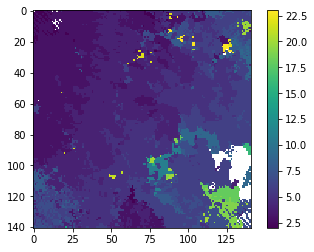

In [257]:
range_array, max_hour = get_daily_range(datetime.datetime(2006,1,1), 1)
plt.imshow(max_hour)
plt.colorbar()

In [214]:
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=36, project='rainfall', walltime='1:15:00', 
                       job_cpu=36, memory='128GB', processes=18)

cluster.scale(36)         # Ask for ten workers

from dask.distributed import Client
client = Client(cluster)  # Connect this local process to remote workers

# wait for jobs to arrive, depending on the queue, this may take some time

import dask.array as da

In [220]:
client

Client Scheduler: tcp://140.221.70.7:46873 Dashboard: http://140.221.70.7:8787/status,Cluster Workers: 18 Cores: 36 Memory: 127.98 GB


In [350]:
yr = 1998
date_list = np.unique([x.date() for x in time_list])
date_list_filtered = date_list[[x.year == yr for x in date_list]]
the_bag = db.from_sequence(date_list_filtered)
rain = lambda x: get_daily_range(x,3)
daily_rain = the_bag.map(rain).compute()

In [351]:
rain_range = np.stack([x[0] for x in daily_rain])
max_phase = np.stack([x[1] for x in daily_rain])

In [352]:
hist, bins = np.histogram(max_phase, bins=range(25))

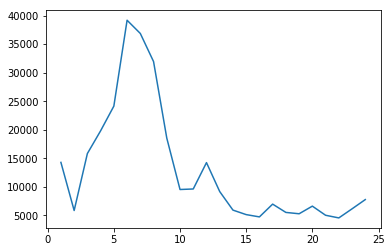

In [353]:
plt.plot(bins[1:], hist)

In [354]:
dros_index_new = np.zeros(rain_range.shape[0])
mjo_index_new = np.zeros(rain_range.shape[0])
i = 0
date_list_new = [np.datetime64(x) for x in date_list_filtered]

for days in date_list_filtered:
    dros_index_new[i] = np.median(dros_index[np.where(x.date() == days for x in time_list)[0]])
    mjo_index_new[i] = np.median(mjo_index[np.where(x.date() == days for x in time_list)[0]])
new_ds = xarray.Dataset({'dros_index': (['time'],dros_index_new),
                         'mjo_index': (['time'],mjo_index_new),
                         'max_phase': (['time', 'x', 'y'], max_phase),
                         'rain_range': (['time', 'x', 'y'], rain_range),
                         'lats': (['x', 'y'], lats),
                         'lons': (['x', 'y'], lons)},
                          coords={'time': date_list_new, 
                                  'x': np.arange(0, lats.shape[0]), 'y': np.arange(0, lons.shape[1])})
new_ds.to_netcdf(('range_rr_' + str(yr) + '.nc'))

In [356]:
rr_range_ds = xarray.open_mfdataset('range_rr*.nc')
rr_range_ds

<xarray.Dataset>
Dimensions:     (time: 2625, x: 141, y: 141)
Coordinates:
  * x           (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * y           (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * time        (time) datetime64[ns] 1998-12-06 1998-12-07 1998-12-09 ...
Data variables:
    dros_index  (time) float64 dask.array<shape=(2625,), chunksize=(20,)>
    mjo_index   (time) float64 dask.array<shape=(2625,), chunksize=(20,)>
    max_phase   (time, x, y) float64 dask.array<shape=(2625, 141, 141), chunksize=(20, 141, 141)>
    rain_range  (time, x, y) float32 dask.array<shape=(2625, 141, 141), chunksize=(20, 141, 141)>
    lats        (time, x, y) float64 dask.array<shape=(2625, 141, 141), chunksize=(20, 141, 141)>
    lons        (time, x, y) float64 dask.array<shape=(2625, 141, 141), chunksize=(20, 141, 141)>

In [380]:
max_phase = rr_range_ds.max_phase.values
max_phase = max_phase+9.5
max_phase[max_phase > 24] = max_phase[max_phase > 24] - 24
hist_mjoactiveb, bins = np.histogram(max_phase[np.logical_and.reduce((dros_index == 0, mjo_index > 3, mjo_index < 8))],
                                   bins=range(25), normed=True)
hist_mjoactivem, bins = np.histogram(max_phase[np.logical_and.reduce((dros_index == 1, mjo_index > 3, mjo_index < 8))],
                                      bins=range(25), normed=True)
hist_mjoinactiveb, bins = np.histogram(max_phase[np.logical_and.reduce((dros_index == 0, 
                                                                        np.logical_or(mjo_index < 4, mjo_index == 8)))],
                                      bins=range(25), normed=True)
hist_mjoinactivem, bins = np.histogram(max_phase[np.logical_and.reduce((dros_index == 1, 
                                                                        np.logical_or(mjo_index < 4, mjo_index == 8)))],
                                      bins=range(25), normed=True)

Text(0.5,1,'Hour of maximum rainfall')

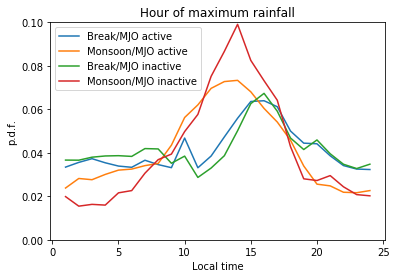

In [400]:
plt.plot(bins[1:], hist_mjoactiveb, label='Break/MJO active')
plt.plot(bins[1:], hist_mjoactivem, label='Monsoon/MJO active')
plt.plot(bins[1:], hist_mjoinactiveb, label='Break/MJO inactive')
plt.plot(bins[1:], hist_mjoinactivem, label='Monsoon/MJO inactive')
plt.ylim([0, 0.1])
plt.legend()
plt.xlabel('Local time')
plt.ylabel('p.d.f.')
plt.title('Hour of maximum rainfall')

Text(0.5,1,'Break, active MJO')

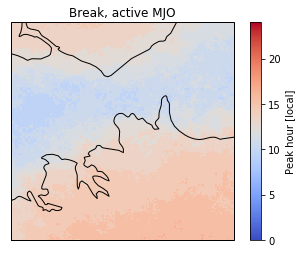

In [411]:
ax = plt.axes(projection=ccrs.PlateCarree())
p = ax.pcolormesh(lons, lats, 
                  np.nanmedian(max_phase[np.logical_and.reduce((dros_index == 0, mjo_index > 3, mjo_index < 8))], axis=0),
                  vmin=0, vmax=24, cmap='coolwarm')
ax.coastlines(resolution='10m')
plt.colorbar(p, ax=ax, label='Peak hour [local]')
ax.set_title('Break, active MJO')

Text(0.5,1,'Monsoon, active MJO')

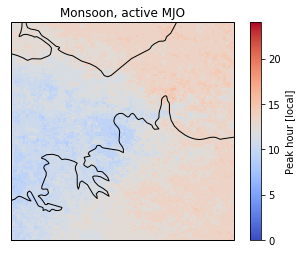

In [415]:
ax = plt.axes(projection=ccrs.PlateCarree())
p = ax.pcolormesh(lons, lats, 
                  np.nanmedian(max_phase[np.logical_and.reduce((dros_index == 1, mjo_index > 3, mjo_index < 8))], axis=0),
                  vmin=0, vmax=24, cmap='coolwarm')
ax.coastlines(resolution='10m')
plt.colorbar(p, ax=ax, label='Peak hour [local]')
ax.set_title('Monsoon, active MJO')

Text(0.5,1,'Monsoon, inactive MJO')

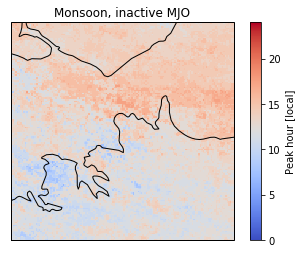

In [413]:
ax = plt.axes(projection=ccrs.PlateCarree())
p = ax.pcolormesh(lons, lats, 
                  np.nanmedian(max_phase[np.logical_and.reduce((dros_index == 1, 
                                                                np.logical_or(mjo_index < 3, mjo_index == 8)))], axis=0),
                  vmin=0, vmax=24, cmap='coolwarm')
ax.coastlines(resolution='10m')
plt.colorbar(p, ax=ax, label='Peak hour [local]')
ax.set_title('Monsoon, inactive MJO')

Text(0.5,1,'Break, inactive MJO')

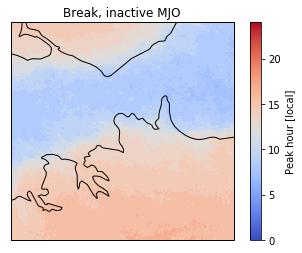

In [414]:
ax = plt.axes(projection=ccrs.PlateCarree())
p = ax.pcolormesh(lons, lats, 
                  np.nanmedian(max_phase[np.logical_and.reduce((dros_index == 0, 
                                                                np.logical_or(mjo_index < 3, mjo_index == 8)))], axis=0),
                  vmin=0, vmax=24, cmap='coolwarm')
ax.coastlines(resolution='10m')
plt.colorbar(p, ax=ax, label='Peak hour [local]')
ax.set_title('Break, inactive MJO')